# TIME SERIES FORECAST WITH SCIKIT-LEARN

## TABLE OF CONTENTS
1. OVERVIEW
2. DATA EXPLORATION AND FEATURE ENGINEERING
    * 2-1. Load data
    * 2-2. Missing data
    * 2-3. Casting to numerical
    * 2-4. Adding features
    * 2-5. Time series components
    * 2-6. Linear correlations: Heatmap and Scatterplots
3. MODEL SELECTION
4. TRAINING AND EVALUATION
5. PREDICTIONS
6. CONCLUSION
7. FUTURE WORK
8. REFERENCES

## 1. OVERVIEW

In this project we will use the [Austin Weather](https://www.kaggle.com/datasets/grubenm/austin-weather) dataset provided by [Kaggle](https://www.kaggle.com/) to forecast the average temperature in Austin Texas using SciKit-Learn.

We can extend this dataset or create a dataset for another city using a weather API like [Weather API](https://www.weatherapi.com/) following the steps from the previous project [ETL PIPELINE WITH PYTHON AND AIRFLOW](https://github.com/Dieg0Maciel/etl_pipeline_with_python_and_airflow) where we studied how to build a pipeline in order to manipulate weather forecast data provided by the [Open Weather](https://openweathermap.org/) API. 


## 2. DATA EXPLORATION AND FEATURE ENGINEERIG

[Austin Weather Dataset](https://www.kaggle.com/datasets/grubenm/austin-weather): Historical temperature, precipitation, humidity, and windspeed for Austin, Texas.

### 2-1. Load data

In [14]:
# Import modules
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

In [2]:
# Load data
github_url = "https://raw.githubusercontent.com/Dieg0Maciel/time_series_forecast_with_scikitlearn/main/"
data_url = github_url + "austin_weather.csv"
data = pd.read_csv(data_url)

# Since we are working with time series, lets set our index to be the date
data = data.set_index("Date")

# Cast the index as a datetime type
data.index = pd.to_datetime(data.index)

# Load data description
description_url = github_url + "data_description.json"
data_description = requests.get(description_url).json()

# Print data info
data.info()

# Print data description
pd.DataFrame.from_dict(data_description, orient="index")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1319 entries, 2013-12-21 to 2017-07-31
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   TempHighF                   1319 non-null   int64 
 1   TempAvgF                    1319 non-null   int64 
 2   TempLowF                    1319 non-null   int64 
 3   DewPointHighF               1319 non-null   object
 4   DewPointAvgF                1319 non-null   object
 5   DewPointLowF                1319 non-null   object
 6   HumidityHighPercent         1319 non-null   object
 7   HumidityAvgPercent          1319 non-null   object
 8   HumidityLowPercent          1319 non-null   object
 9   SeaLevelPressureHighInches  1319 non-null   object
 10  SeaLevelPressureAvgInches   1319 non-null   object
 11  SeaLevelPressureLowInches   1319 non-null   object
 12  VisibilityHighMiles         1319 non-null   object
 13  VisibilityAvgMiles          13

,0
Date,YYYY-MM-DD from 2013-12-21 to 2017-07-31
TempHighF,"High temperature, in Fahrenheit"
TempAvgF,"Average temperature, in Fahrenheit"
TempLowF,"Low temperature, in Fahrenheit"
DewPointHighF,"High dew point, in Fahrenheit"
DewPointAvgF,"Average dew point, in Fahrenheit"
DewPointLowF,"Low dew point, in Fahrenheit"
HumidityHighPercent,"High humidity, as a percentage"
HumidityAvgPercent,"Average humidity, as a percentage"
HumidityLowPercent,"Low humidity, as a percentage"


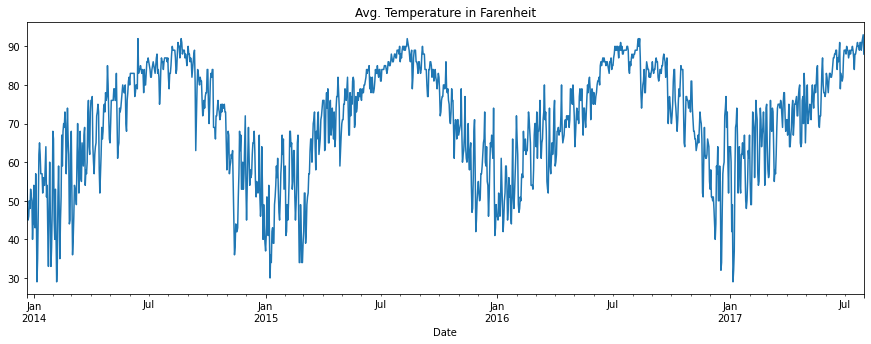

In [3]:
# Data plot
data["TempAvgF"].plot(figsize=(15, 5), title='Avg. Temperature in Farenheit')
plt.show()

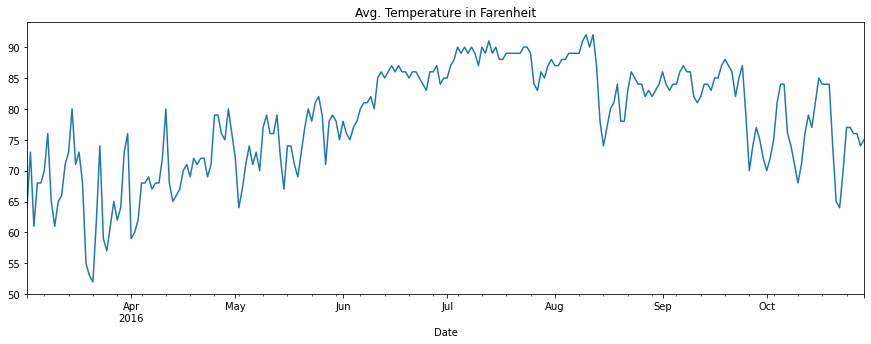

In [4]:
data["TempAvgF"].loc[(data.index > '2016-03-01') & (data.index < '2016-10-30')] \
    .plot(figsize=(15, 5), title='Avg. Temperature in Farenheit')
plt.show()

### 2-2. Missing data

In [5]:
"""
PrecipitationSumInches column:
    Using the *.unique()* method to see how the data has been encoded 
    we conclude there are no missing values.The string *'T'* represent 
    traces of precipitation in PrecipitationSumInches column 
"""
data['PrecipitationSumInches'].unique()

array(['0.46', '0', 'T', '0.16', '0.1', '0.01', '0.06', '0.05', '0.02',
       '0.15', '0.11', '0.08', '0.17', '0.74', '0.07', '0.2', '0.27',
       '1.34', '2.45', '0.94', '0.14', '0.19', '1.56', '1.75', '0.55',
       '1.49', '0.24', '0.49', '0.31', '3.53', '1.52', '0.09', '0.98',
       '0.22', '0.51', '0.68', '0.35', '3.66', '0.13', '0.21', '0.03',
       '1.42', '0.3', '0.56', '1.51', '0.04', '0.33', '3.33', '0.59',
       '0.63', '0.76', '2.07', '0.4', '0.26', '0.45', '2.17', '1.17',
       '0.43', '0.41', '0.57', '3.84', '0.29', '0.23', '1.12', '0.36',
       '2.6', '1.41', '5.2', '0.67', '2.66', '1.09', '0.93', '0.75',
       '1.05', '0.79', '4.79', '0.65', '4.93', '0.89', '0.53', '1.03',
       '1.46', '0.25', '1.54', '1.32', '1.33', '2.18', '0.34', '1.19',
       '1.13', '0.58', '0.54', '0.92', '0.77', '2.25', '0.52', '0.18',
       '1.07', '1.61', '1.06', '2.35', '1.79', '1.22', '1.29', '0.37',
       '0.61', '1.57', '0.86', '0.66', '0.73', '0.71', '0.12', '0.47',
       '1.

In [6]:
"""
Event column:
    Using the .unique() method to see how the data has been encoded 
    we conclude there are no missing values. The string ' ' represent 
    no event in the Event column
"""

data["Events"].unique()

array(['Rain , Thunderstorm', ' ', 'Rain', 'Fog', 'Rain , Snow',
       'Fog , Rain', 'Thunderstorm', 'Fog , Rain , Thunderstorm',
       'Fog , Thunderstorm'], dtype=object)

In [7]:
"""
TempHighF, TempAvgF, TempLowF columns
"""

data[['TempHighF', 'TempAvgF', 'TempLowF']].isnull().sum()

TempHighF    0
TempAvgF     0
TempLowF     0
dtype: int64

In [8]:
"""
Numerical columns encoded as strings:
    We should be careful using the pandas method .isnull() for numerical columns 
    were the data is encoded as strings. In this particular dataset missing values 
    were encoded as "-". Therefore, counting the number of strings "-" for each column 
    gives us the amount of missing values
"""

cols = data.columns.to_list()
cols_to_exclude = [
    'Date', 'TempHighF', 'TempAvgF', 'TempLowF', 'PrecipitationSumInches', 'Events'
]
cols_to_transfor_to_numeric = [col for col in cols if col not in cols_to_exclude]

for col in cols_to_transfor_to_numeric:
    print(f"{col}: {data[col][data[col] == '-'].count()}")

DewPointHighF: 7
DewPointAvgF: 7
DewPointLowF: 7
HumidityHighPercent: 2
HumidityAvgPercent: 2
HumidityLowPercent: 2
SeaLevelPressureHighInches: 3
SeaLevelPressureAvgInches: 3
SeaLevelPressureLowInches: 3
VisibilityHighMiles: 12
VisibilityAvgMiles: 12
VisibilityLowMiles: 12
WindHighMPH: 2
WindAvgMPH: 2
WindGustMPH: 4


### 2-3. Casting to numerical

In [9]:
"""
PrecipitationSumInches column:
    Since the categorical value 'T' corresponds to traces, lets separate it 
    from PrecipitationSumInches by replacing 'T' for '0.001' 
"""

# Replace 'T' by '0.001'
precipitation = data.PrecipitationSumInches.to_list()
for i, p in enumerate(precipitation):
    if p == 'T':
        precipitation[i] = '0.001'
data['PrecipitationSumInches'] = precipitation

# Cast PrecipitationSumInches as numeric
data['PrecipitationSumInches'] = pd.to_numeric(data['PrecipitationSumInches'], errors='coerce')

In [10]:
"""
Numerical columns encoded as strings
"""

for col in cols_to_transfor_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
# Use the method .isnull() to check if errors='coerce' worked properly
data[cols_to_transfor_to_numeric].isnull().sum()

DewPointHighF                  7
DewPointAvgF                   7
DewPointLowF                   7
HumidityHighPercent            2
HumidityAvgPercent             2
HumidityLowPercent             2
SeaLevelPressureHighInches     3
SeaLevelPressureAvgInches      3
SeaLevelPressureLowInches      3
VisibilityHighMiles           12
VisibilityAvgMiles            12
VisibilityLowMiles            12
WindHighMPH                    2
WindAvgMPH                     2
WindGustMPH                    4
dtype: int64

### 2-4. Adding features

In [11]:
"""
Event colum:
    Create a feature for each event and drop the Event column
"""

rain = ['Rain','Fog , Rain', 'Rain , Thunderstorm', 'Rain , Snow', 'Fog , Rain , Thunderstorm']
fog = ['Fog','Fog , Rain', 'Fog , Thunderstorm', 'Fog , Rain , Thunderstorm']
snow = ['Snow', 'Rain , Snow']
thunderstorm = ['Thunderstorm', 'Rain , Thunderstorm', 'Fog , Thunderstorm', 'Fog , Rain , Thunderstorm']

# Add a new feature for each event
data["Rain"] = [event in rain for event in data.Events.to_list()]
data["Fog"] = [event in fog for event in data.Events.to_list()]
data["Snow"] = [event in snow for event in data.Events.to_list()]
data["Thunderstorm"] = [event in thunderstorm for event in data.Events.to_list()]

# Drop Events column
data.drop('Events', inplace=True, axis=1)

### 2-5. Time series components

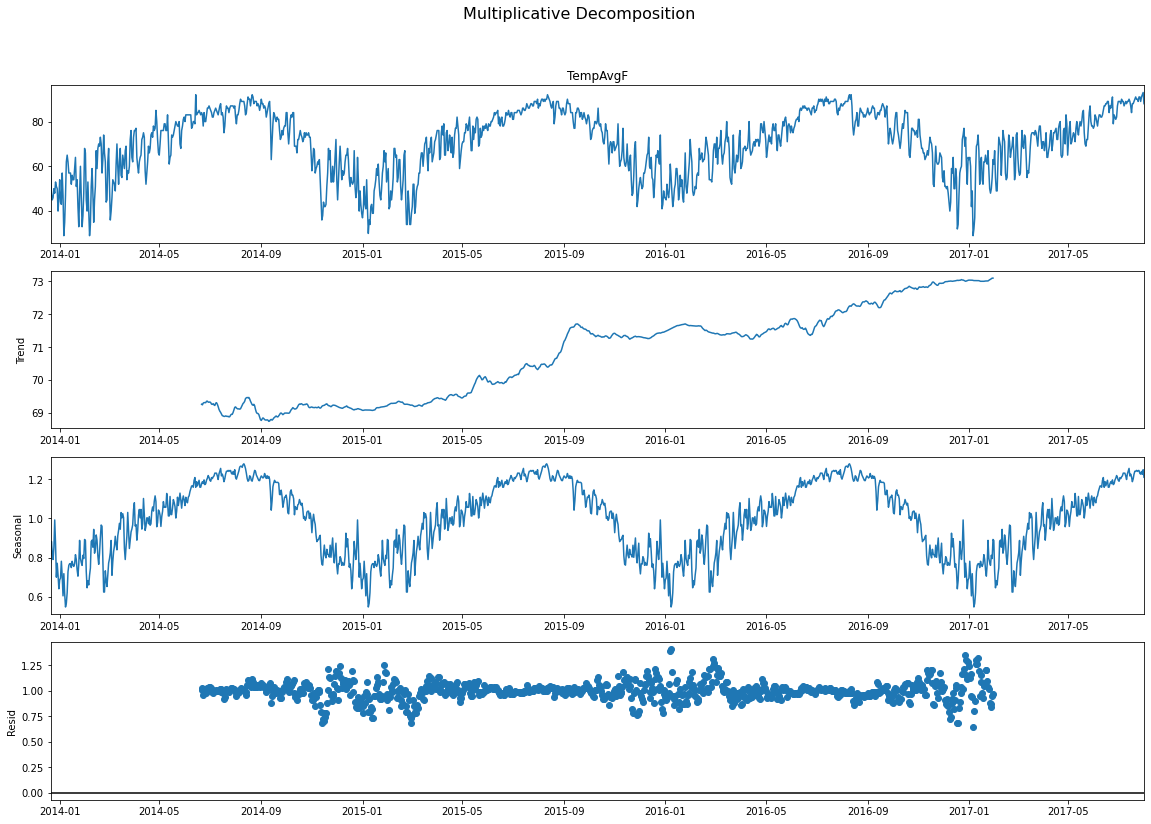

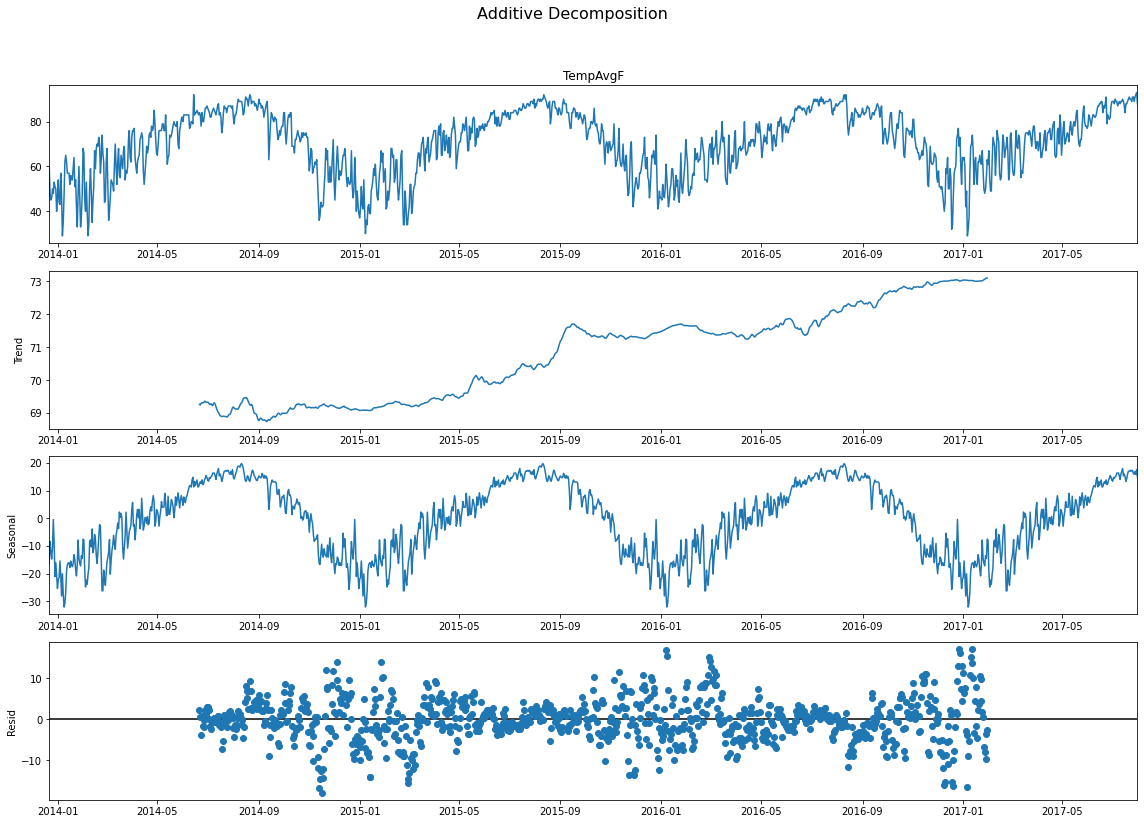

In [12]:
period = 365 # in days

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(
    data["TempAvgF"], model="multiplicative", period=period
)

# Additive Decomposition 
additive_decomposition = seasonal_decompose(
    data["TempAvgF"], model="additive", period=period
)

#Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

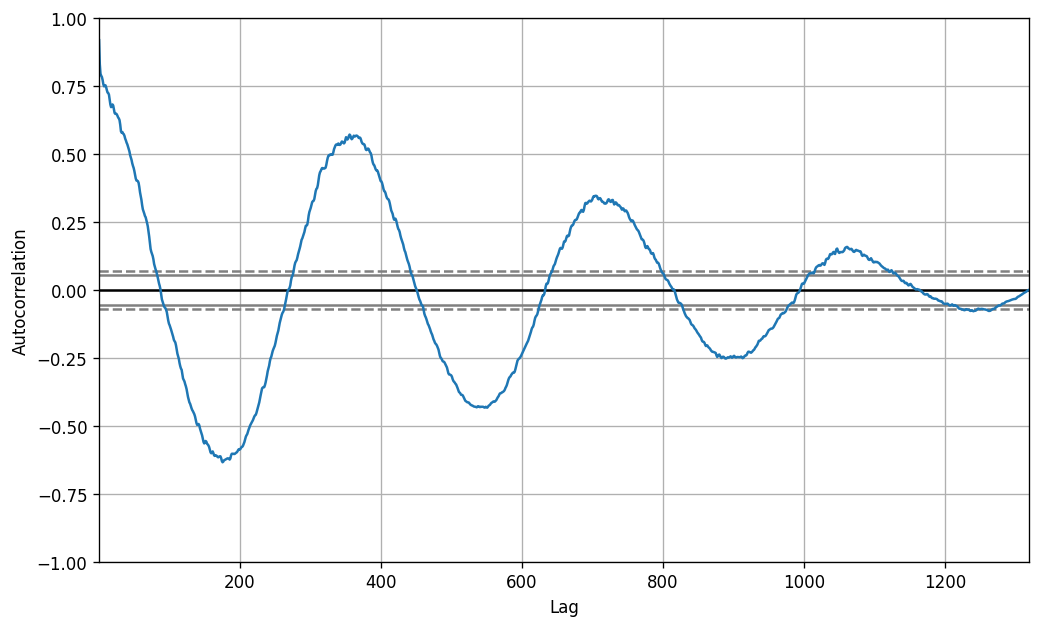

In [13]:
"""
Autocorrelation Function (ACF) plot.
"""
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(data["TempAvgF"].tolist())
plt.show()

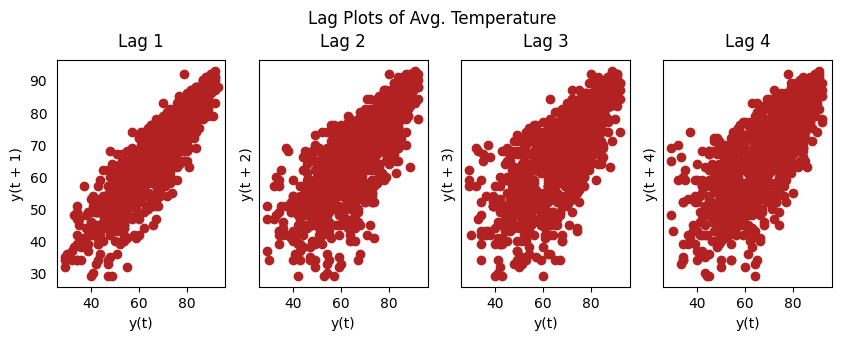

In [16]:
"""
Lag Plots
"""
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(data["TempAvgF"], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Avg. Temperature', y=1.05)    
plt.show()

### 2-6. Linear correlations: Heatmap and Scatterplots

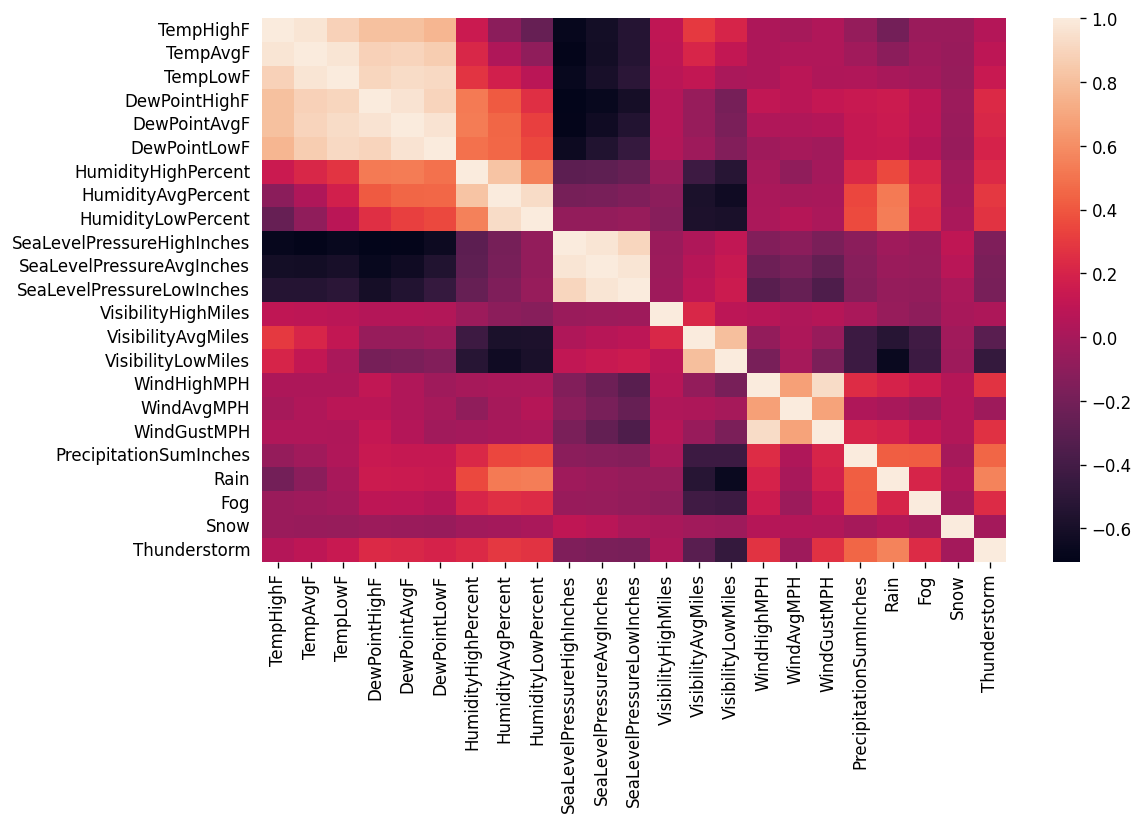

In [19]:
"""
Heatmap
"""
sns.heatmap(data.corr())
plt.show()

#### Scatterplots

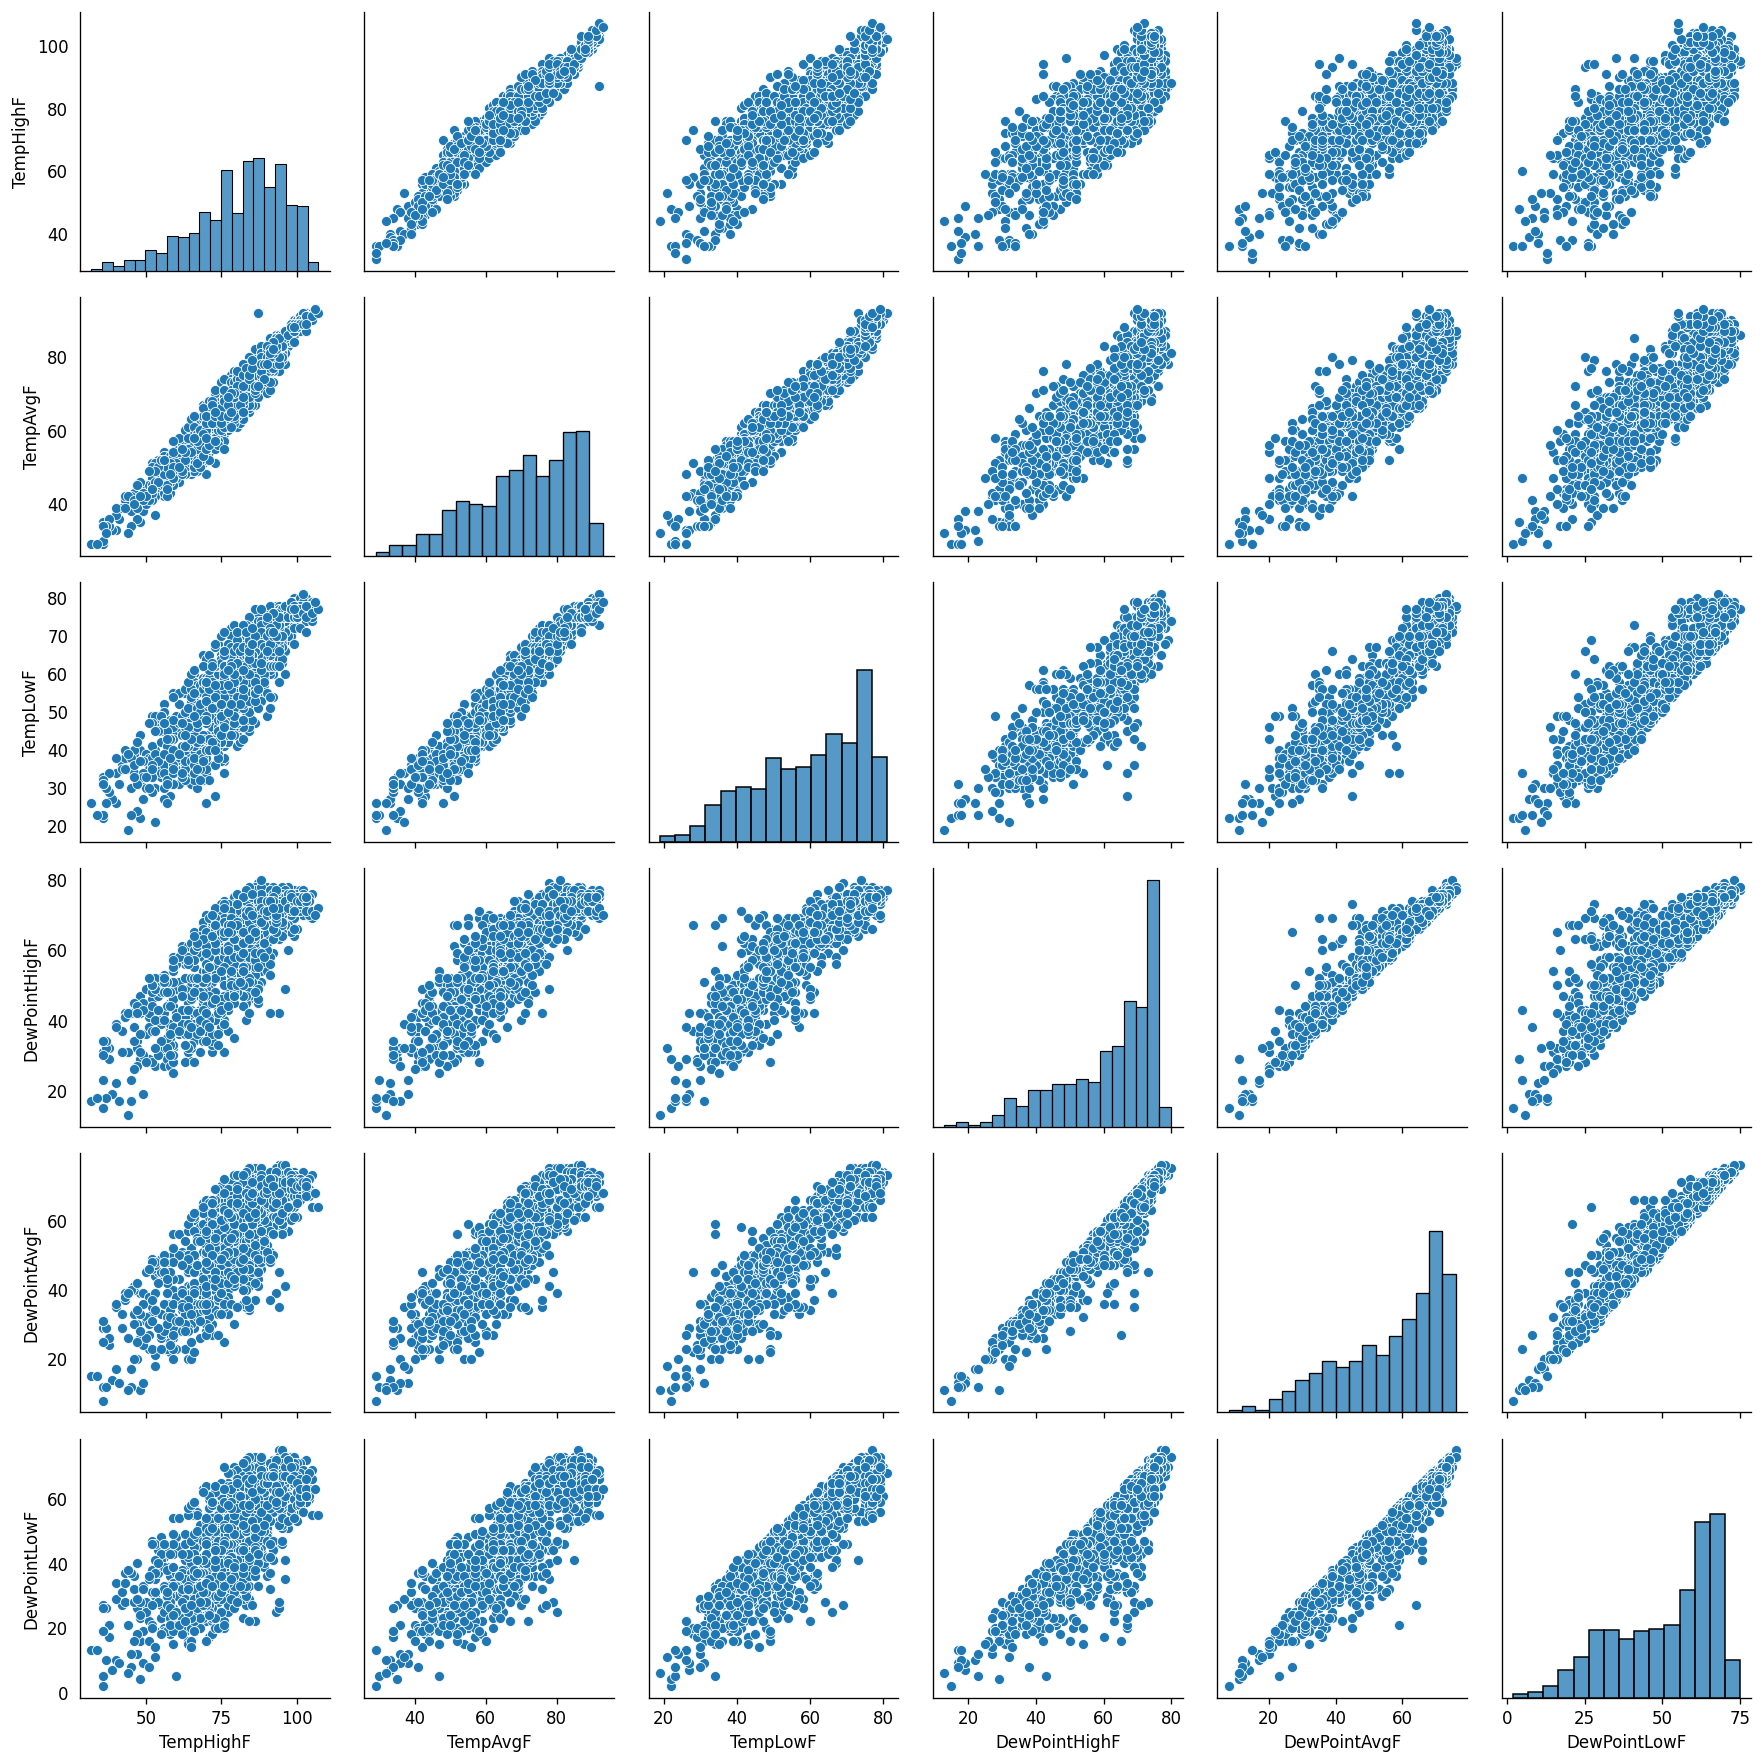

In [27]:
numeric_cols = [
    'TempHighF',
    'TempAvgF',
    'TempLowF',
    'DewPointHighF',
    'DewPointAvgF',
    'DewPointLowF'
]

g = sns.PairGrid(data[numeric_cols])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

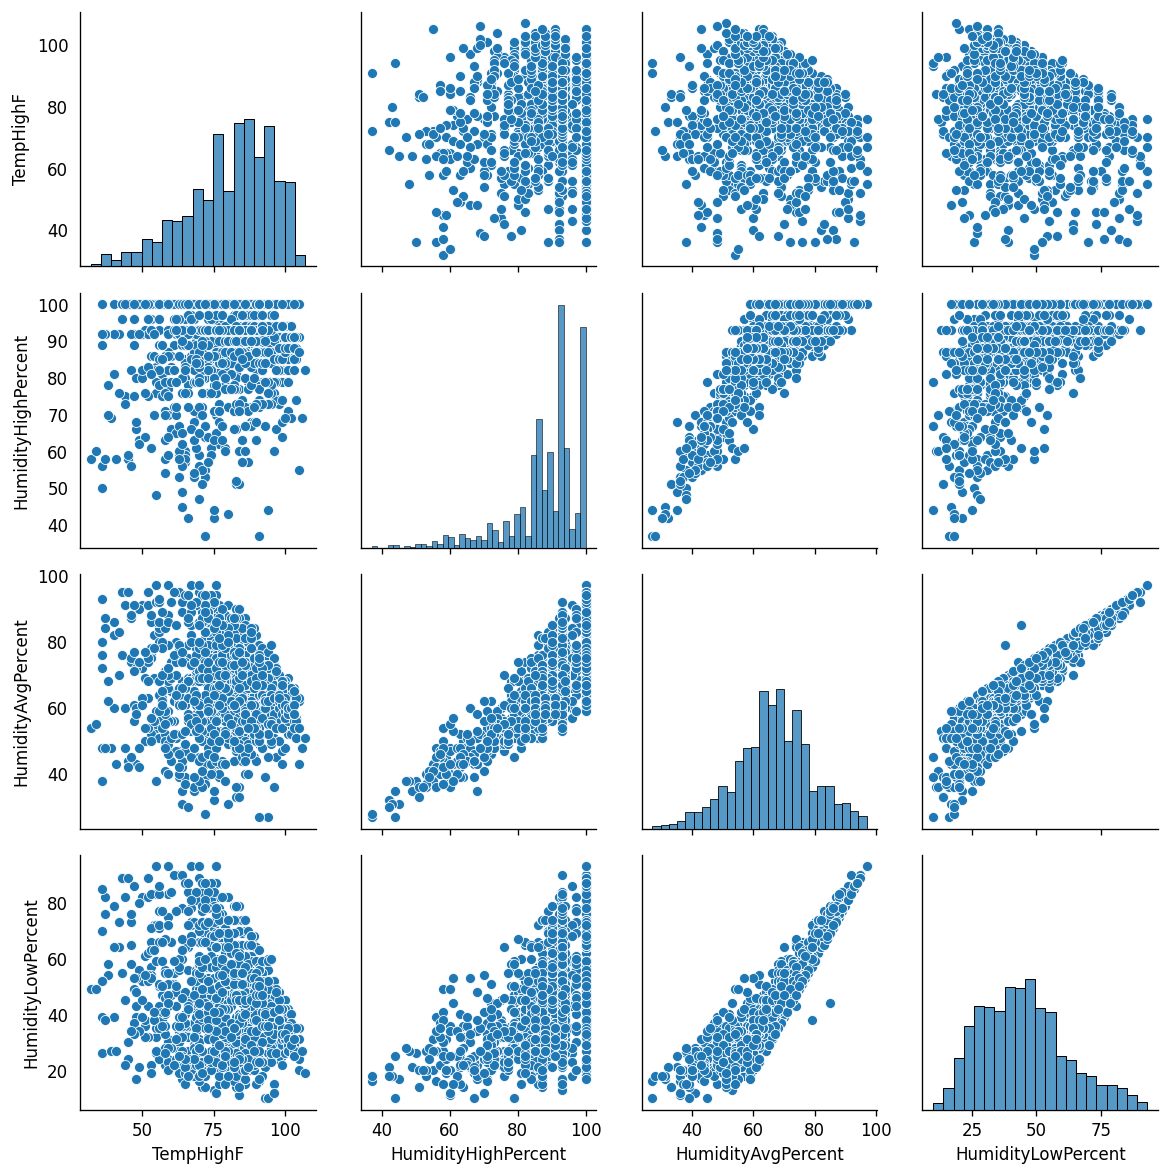

In [28]:
numeric_cols = [
    'TempHighF',
    'HumidityHighPercent',
    'HumidityAvgPercent',
    'HumidityLowPercent',
]

g = sns.PairGrid(data[numeric_cols])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

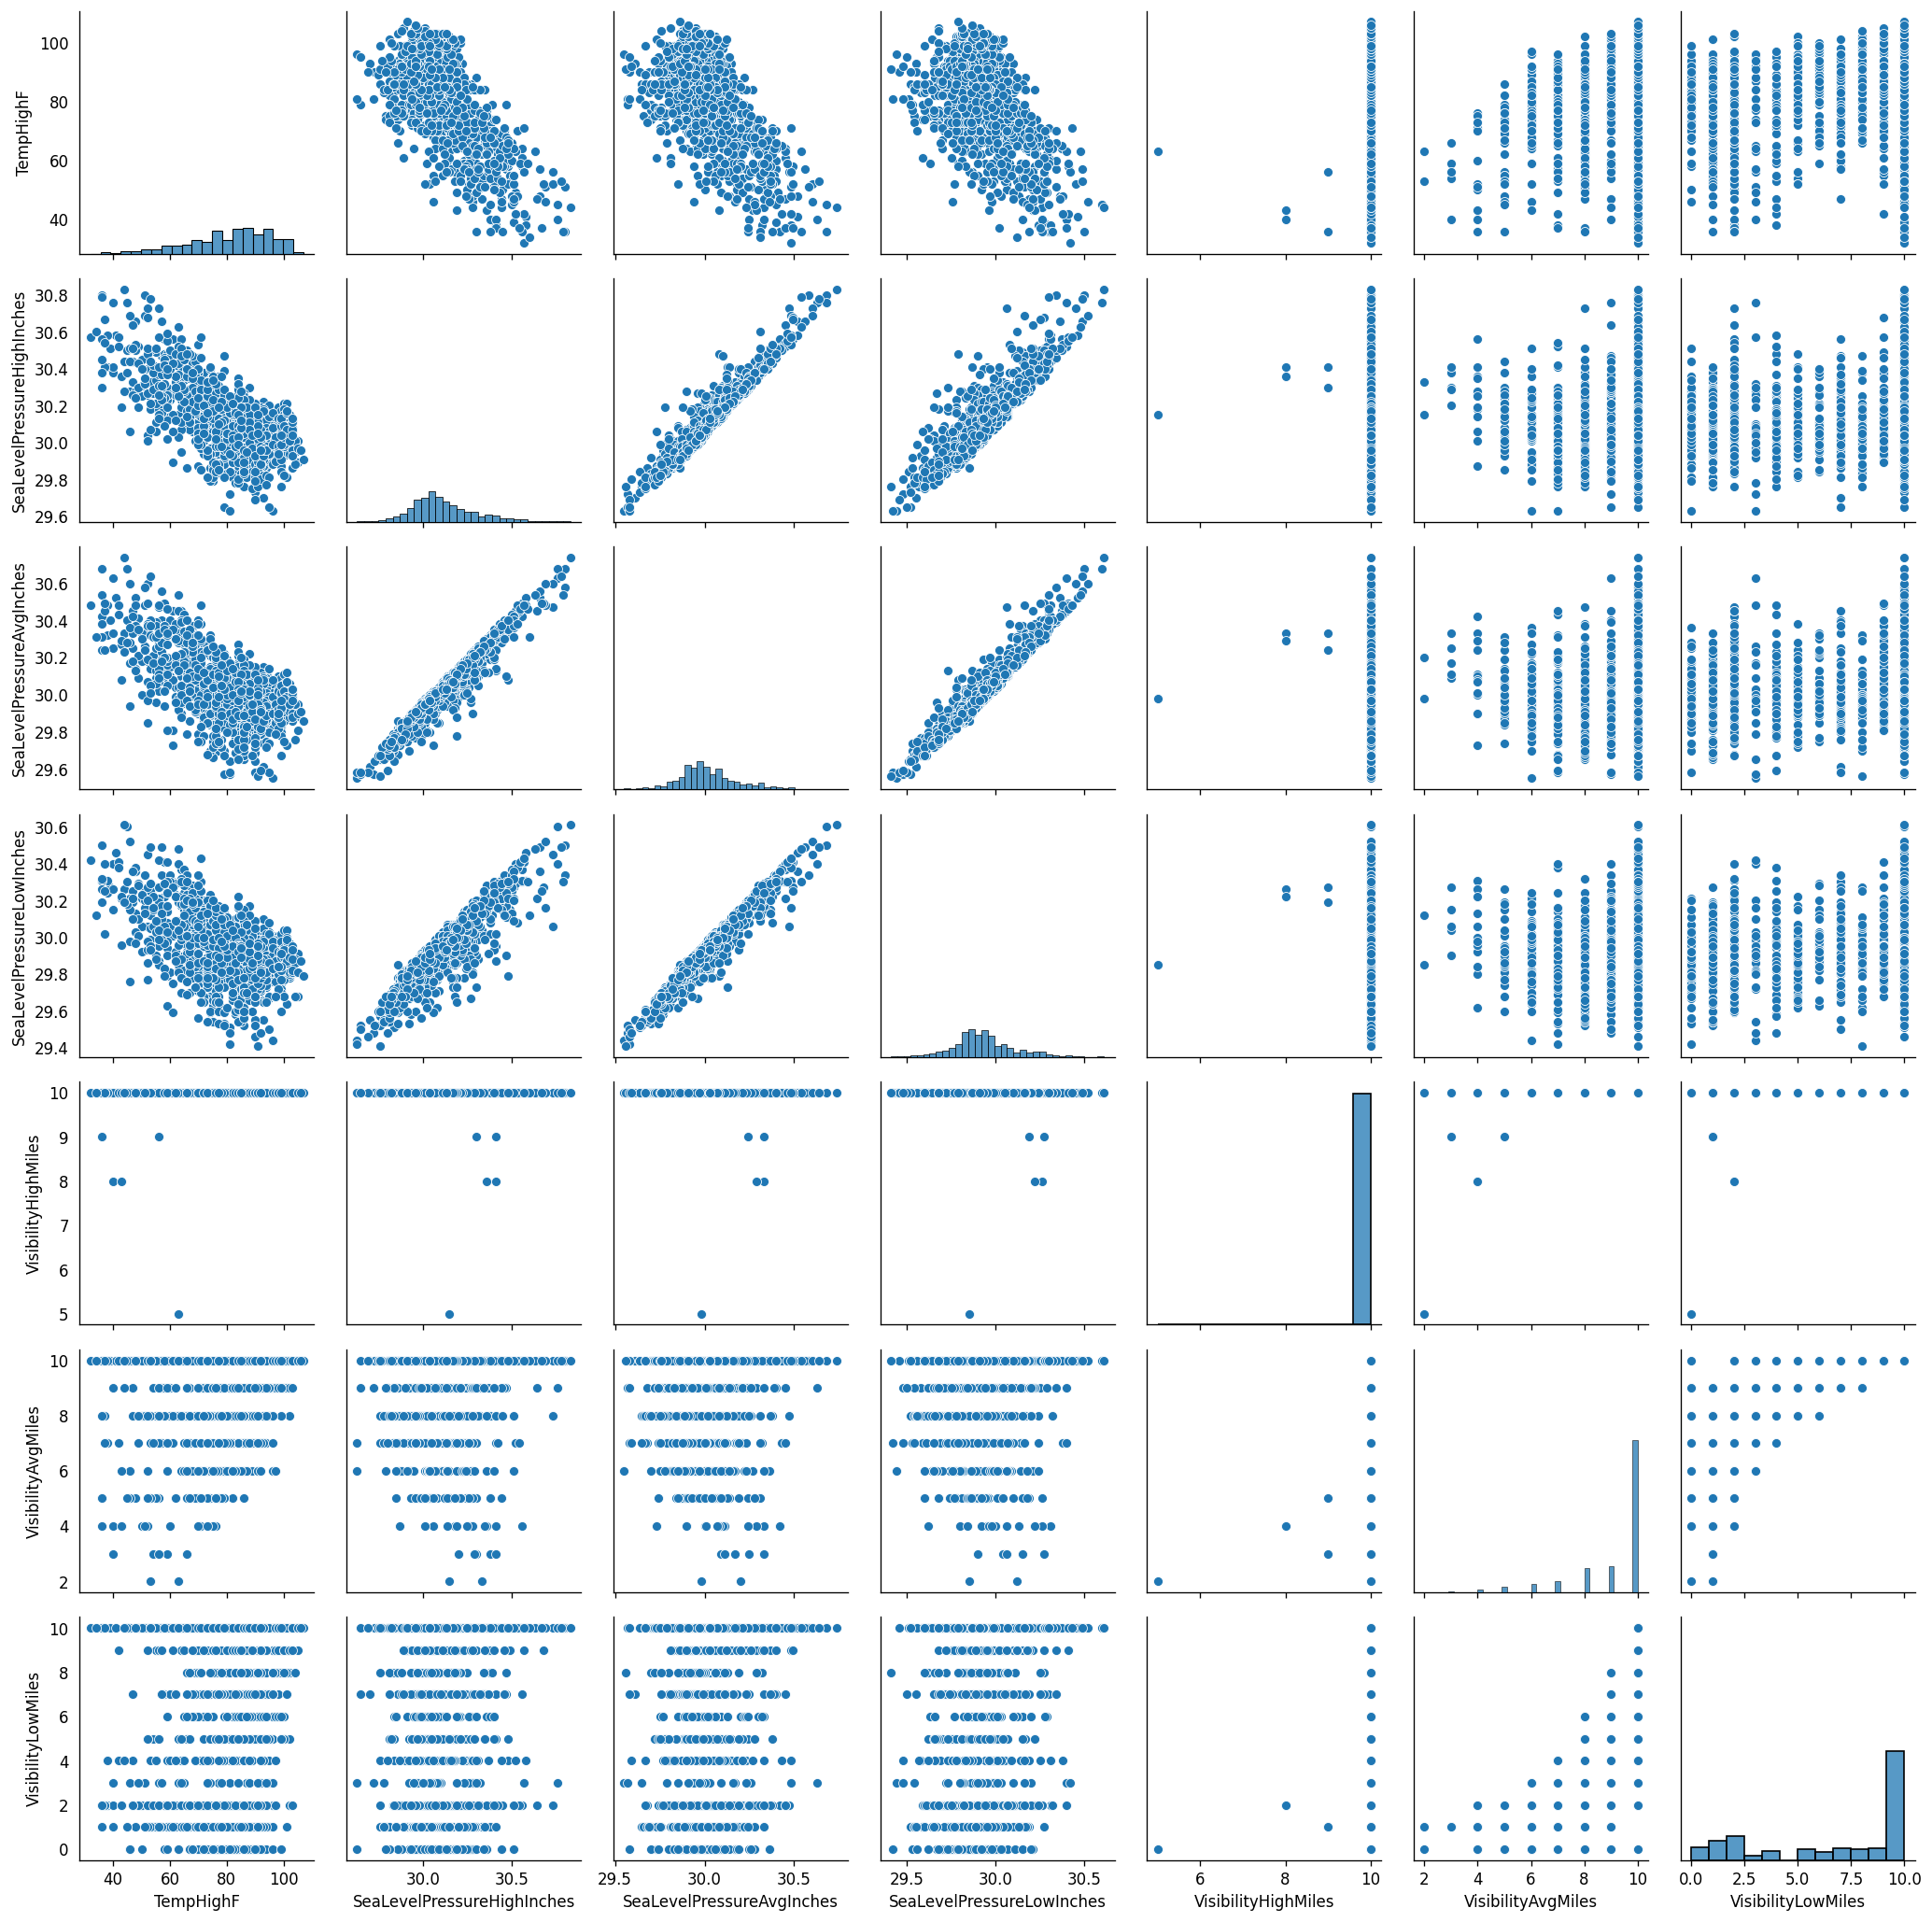

In [29]:
numeric_cols = [
    'TempHighF',
    'SeaLevelPressureHighInches',
    'SeaLevelPressureAvgInches',
    'SeaLevelPressureLowInches',
    'VisibilityHighMiles',
    'VisibilityAvgMiles',
    'VisibilityLowMiles'
]

g = sns.PairGrid(data[numeric_cols])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

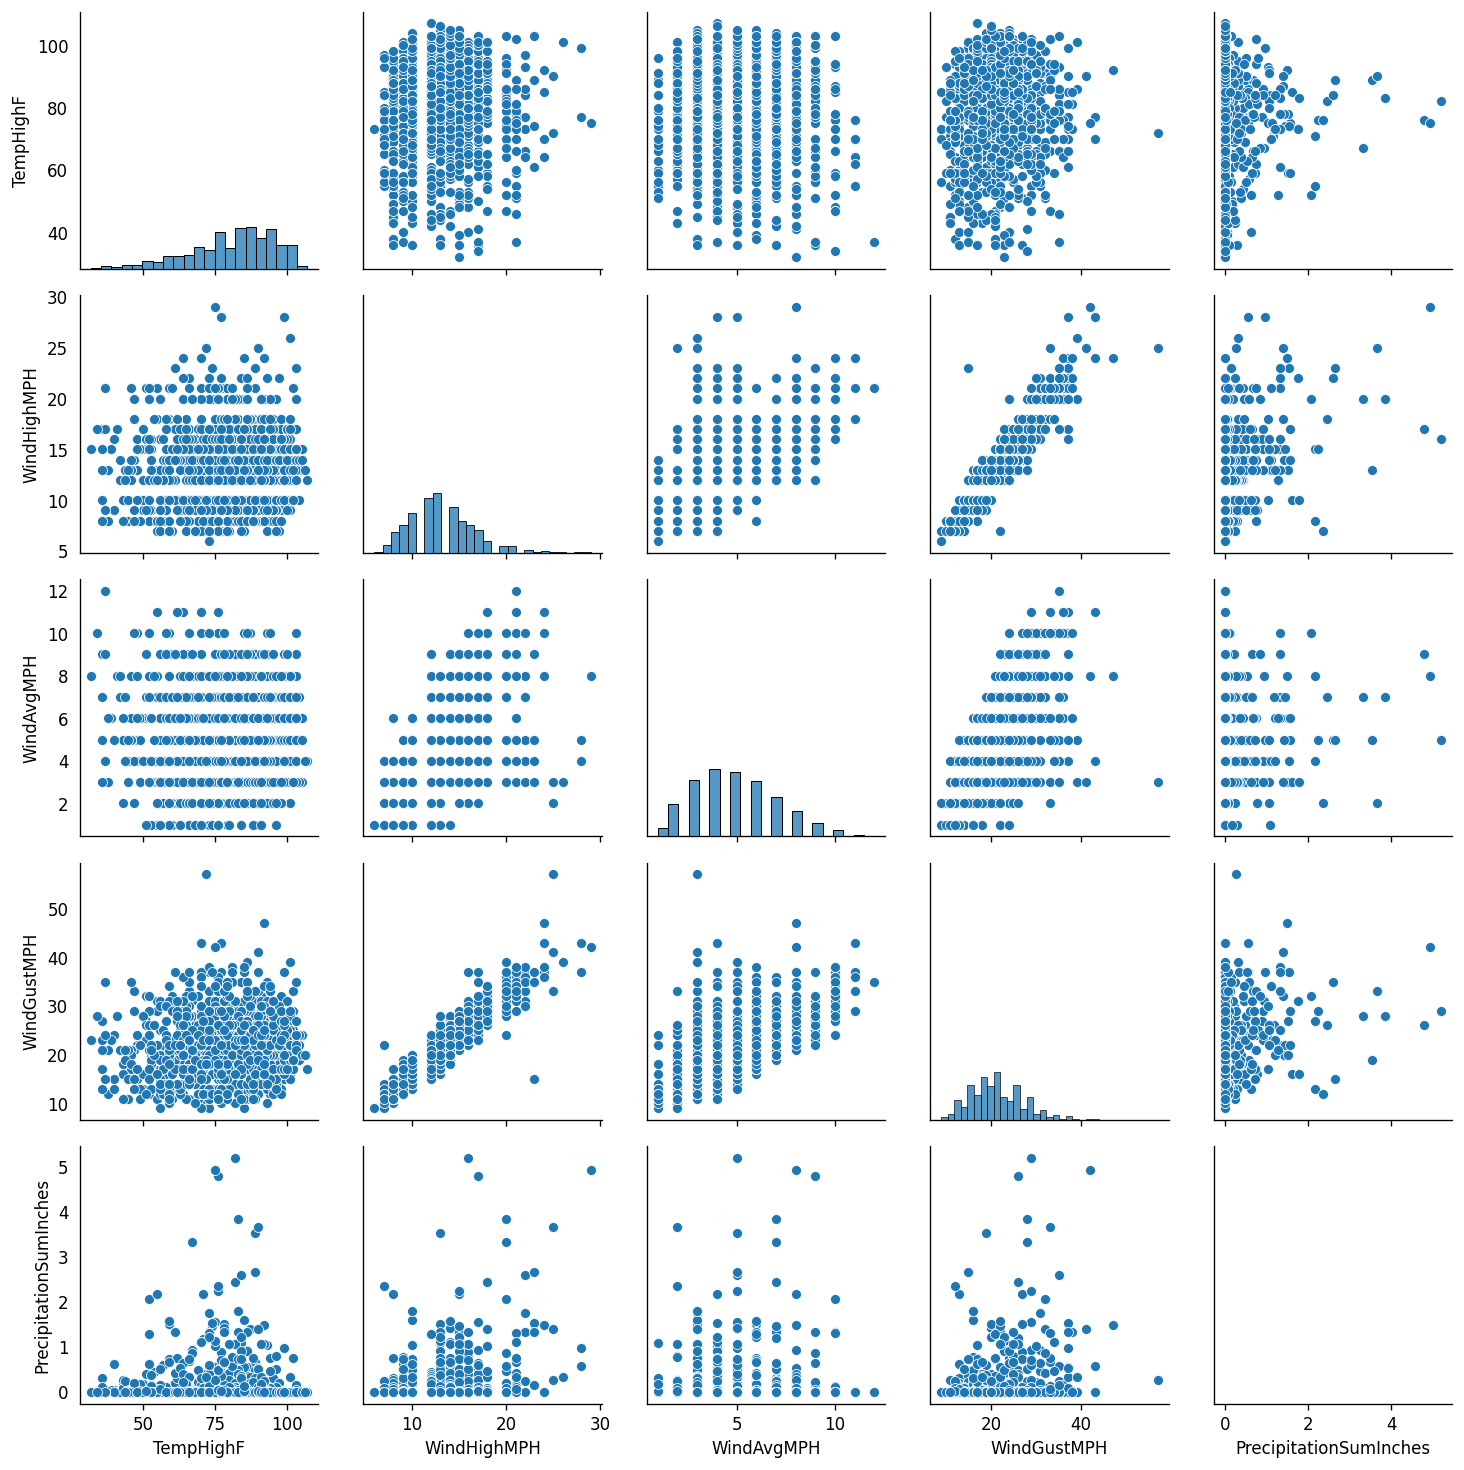

In [30]:
numeric_cols = [
    'TempHighF',
    'WindHighMPH',
    'WindAvgMPH',
    'WindGustMPH',
    'PrecipitationSumInches'
]

g = sns.PairGrid(data[numeric_cols])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

## 3. MODEL SELECTION

## 4. TRAINING AND EVALUATION

## 5. PREDICTIONS 

## 6. CONCLUSION 

## 7. FUTURE WORK

## 8. REFERENCES

* [Project link](https://github.com/Dieg0Maciel/time_series_forecast_with_scikitlearn)
* [Temperature prediction time series](https://www.kaggle.com/code/tudorpreduna/temperature-pred-time-series)
* [Time Series Forecasting with XGBoost](https://www.youtube.com/watch?v=vV12dGe_Fho)
* [Finding Seasonal Trends in Time-Series Data with Python](https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861)
* [Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
* [Time Series as Features](https://www.kaggle.com/code/ryanholbrook/time-series-as-features)